# Retrieval Augmented Generation evaluation

### LOADING

#### Load Embedings

In [258]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, CrossEncoder, util

# Load dataset
task_prompts_df = pd.read_csv('dataset/task_prompts.csv')
nodes_df = pd.read_csv('dataset/nodes.csv')

print("Task prompts:", task_prompts_df.shape)
print("Nodes:", nodes_df.shape)

# Load embedings
task_prompt_embedings = np.load('dataset/task_prompts_embeddings.npy')
nodes_texts_embedings = np.load('dataset/nodes_texts_embeddings.npy')

print("Task prompts embedings:", task_prompt_embedings.shape)
print("Nodes texts embedings:", nodes_texts_embedings.shape)

# Prepare model
model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

Task prompts: (30, 2)
Nodes: (161140, 8)
Task prompts embedings: (30, 768)
Nodes texts embedings: (161140, 768)


/home/vicentamen/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### EVALUATE TASKS

In [259]:
# Get the nodes indexes for a given task_id
def get_nodes_indexes(action_id, nodes_df):
    return nodes_df[nodes_df['action_id'] == action_id].index


def get_nodes_embeddigs(nodes_indexes, nodes_texts_embedings):
    return nodes_texts_embedings[nodes_indexes]


def get_task_embedings(task_index, task_prompt_embedings):
    # Get the task prompt embedings
    task_embedints = task_prompt_embedings[task_index]    
    return task_embedints

def get_top_nodes(similarities, k=10):
    import tensorflow as tf
    # Get top k nodes, but ensure k is not larger than the number of similarities
    k = min(k, tf.shape(similarities)[0])
    top_values, indices = tf.math.top_k(similarities, k)
    return top_values.numpy().flatten(), indices.numpy().flatten()

def get_top_nodes_with_rerank(similarities, k=10):
    pass


def calculate_pos_candidates_count(relevant_nodes):
    pos_candidates_count = sum(1 for node in relevant_nodes if node['pos_candidate'] == 1)
    pos_candidates_k1_count = sum(1 for node in relevant_nodes if node['pos_candidate_k1'] == 1)
    pos_candidates_k3_count = sum(1 for node in relevant_nodes if node['pos_candidate_k3'] == 1)
    pos_candidates_k5_count = sum(1 for node in relevant_nodes if node['pos_candidate_k5'] == 1)
    
    return {
        'n0 counts': pos_candidates_count, 
        'n1 counts': pos_candidates_k1_count, 
        'n3 counts': pos_candidates_k3_count, 
        'n5 counts': pos_candidates_k5_count
    }
    
def calculate_pos_candidates_count_reranker(relevant_nodes):
    pos_candidates_count = sum(1 for node, _, _ in relevant_nodes if node['pos_candidate'] == 1)
    pos_candidates_n1_count = sum(1 for node, _, _ in relevant_nodes if node['pos_candidate_k1'] == 1)
    pos_candidates_n3_count = sum(1 for node, _, _ in relevant_nodes if node['pos_candidate_k3'] == 1)
    pos_candidates_n5_count = sum(1 for node, _, _ in relevant_nodes if node['pos_candidate_k5'] == 1)
    
    return {
        'n0 counts': pos_candidates_count, 
        'n1 counts': pos_candidates_n1_count, 
        'n3 counts': pos_candidates_n3_count, 
        'n5 counts': pos_candidates_n5_count
    }
    
def calculate_precision(pos_candidates_count):
    return {'n0 precision': 1 if pos_candidates_count['n0 counts'] > 0 else 0, 
            'n1 precision': 1 if pos_candidates_count['n1 counts'] > 0 else 0, 
            'n3 precision': 1 if pos_candidates_count['n3 counts'] > 0 else 0, 
            'n5 precision': 1 if pos_candidates_count['n5 counts'] > 0 else 0,}
    

def evaluate_action(action_df, nodes_df, task_prompt, task_index, task_prompt_embedings, nodes_texts_embedings, model, cross_encoder, k=10):
    action_id = action_df['action_id'].iloc[0]
    results = {}

    # The specific task prompt embeddings
    prompt_embedings = get_task_embedings(task_index, task_prompt_embedings)
    
    # Get the nodes embeddings
    nodes_indexes = get_nodes_indexes(action_id, nodes_df)
    nodes_embedings = get_nodes_embeddigs(nodes_indexes, nodes_texts_embedings)
    
    # Perform semantic search
    hits = util.semantic_search(prompt_embedings, nodes_embedings, top_k=100)
    hits = hits[0]
    
    # Extract the top k nodes and their scores
    top_nodes = [(nodes_df.loc[hit['corpus_id']], hit['score']) for hit in hits]
    
    # Add error checking for reranker
    if not isinstance(reranker, CrossEncoder):
        print(f"Error: reranker is not a CrossEncoder object. It is a {type(reranker)}.")
        # You might want to return early or handle this error appropriately
        return None
    
    # Perform reranking
    try:
        reranker_input = [(task_prompt, node_text.iloc[0]) for node_text, _ in top_nodes]
        reranker_scores = cross_encoder.predict(reranker_input)
    except AttributeError as e:
        print(f"Error when calling reranker.predict: {e}")
        # Handle the error appropriately, maybe by skipping reranking
        reranker_scores = [0] * len(top_nodes)
    
    # Perform reranking
    #reranker_scores = reranker.predict([(task_prompt, node_text.iloc[0]) for node_text, _ in top_nodes])
    
    for idx in range(len(hits)):
        hits[idx]['cross_score'] = reranker_scores[idx]
        
    
    # Store the top k nodes and their scores
    sorted_nodes_values = sorted(hits, key=lambda x: x['score'], reverse=True)[:k]
    sorted_nodes_reranker_values = sorted(hits, key=lambda x: x['cross_score'], reverse=True)[:k]
    # Get the nodes from the values
    sorted_nodes = [nodes_df.loc[node['corpus_id']] for node in sorted_nodes_values]
    sorted_nodes_reranker = [nodes_df.loc[node['corpus_id']] for node in sorted_nodes_reranker_values]
    
    # Calculate the task precision
    novel_counts = calculate_pos_candidates_count(sorted_nodes)
    novel_precision = calculate_precision(novel_counts)
    
    # Compute reranker precision
    reranker_counts = calculate_pos_candidates_count(sorted_nodes_reranker)
    reranker_precision = calculate_precision(reranker_counts)
    
    results = {'novel': novel_precision, 'reranker': reranker_precision, 'novel_nodes': sorted_nodes, 'reranker_nodes': sorted_nodes_reranker}
    
    return results

def evaluate_task(task, nodes_df, task_prompts_df, task_prompt_embedings, nodes_texts_embedings, model, cross_encoder, k=10):
    """
    This function evaluates a task by calculating the precision of the top 10 nodes for all the actions recorded for the task.
    If we wanted to evaluate the model for a single action, we could use the function evaluate_action.
    """
    task_id = task['task_id']
    task_index = task_prompts_df[task_prompts_df['task_id'] == task_id].index[0]
    results = {}
    
    # Get all the action ids for the task
    actions_ids = nodes_df[nodes_df['task_id'] == task_id]['action_id'].unique()
    for action in actions_ids:
        action_df = nodes_df[nodes_df['action_id'] == action]
        prompt = task_prompts_df[task_prompts_df['task_id'] == task_id]['prompt'].iloc[0]

        task_results = evaluate_action(action_df, nodes_df, prompt, task_index, task_prompt_embedings, nodes_texts_embedings, model, cross_encoder, k)
        
        results[action] = task_results
    return results

In [260]:
# Test task evaluation
k_values = [5, 10, 30]
test_task = task_prompts_df.iloc[0]
print("Task:", test_task)
k_results = []
for i, k in enumerate(k_values):
    print(f"Running evaluation for k={k}")
    results = evaluate_task(test_task, nodes_df, task_prompts_df, task_prompt_embedings, nodes_texts_embedings, model, reranker, k)
    k_results.append(results)


Task: task_id                 7bda9645-0b5f-470a-8dd7-6af0bff4da68
prompt     Check for pickup restaurant available in Bosto...
Name: 0, dtype: object
Running evaluation for k=5
Running evaluation for k=10
Running evaluation for k=30


In [261]:
import pandas as pd
from tqdm import tqdm

# Evaluate all tasks
k_values = [5, 10, 30]
results = []
total_tasks = len(task_prompts_df)
for index, row in tqdm(task_prompts_df.iterrows(), total=total_tasks):
    task_results = {'k5': [], 'k10': [], 'k30': []}
    for k in k_values:
        task_results_k = evaluate_task(row, nodes_df, task_prompts_df, task_prompt_embedings, nodes_texts_embedings, model, reranker, k)
        task_results['k' + str(k)] = task_results_k
    results.append(task_results)
    
print('Tasks evaluated: ', len(results))

100%|██████████| 30/30 [10:06<00:00, 20.20s/it]

Tasks evaluated:  30


### RESULTS EVALUATION

In [262]:
k5_counts = 0
k10_counts = 0
k30_counts = 0

total = 0

for task in results:
    for action in task['k30']:
        total += 1
        k5_counts += task['k5'][action]['novel']['n0 precision']
        k10_counts += task['k10'][action]['novel']['n0 precision']
        k30_counts += task['k30'][action]['novel']['n0 precision']
        
print('results naive rag')
print('k5 precision:', k5_counts / total)
print('k10 precision:', k10_counts / total)
print('k30 precision:', k30_counts / total)

results naive rag
k5 precision: 0.026755852842809364
k10 precision: 0.056856187290969896
k30 precision: 0.2408026755852843


In [263]:
k5_counts = 0
k10_counts = 0
k30_counts = 0

total = 0

for task in results:
    for action in task['k30']:
        total += 1
        k5_counts += task['k5'][action]['reranker']['n0 precision']
        k10_counts += task['k10'][action]['reranker']['n0 precision']
        k30_counts += task['k30'][action]['reranker']['n0 precision']

print('results reranker')
print('k5 precision:', k5_counts / total)
print('k10 precision:', k10_counts / total)
print('k30 precision:', k30_counts / total)

results reranker
k5 precision: 0.026755852842809364
k10 precision: 0.06020066889632107
k30 precision: 0.23745819397993312


In [196]:
k5_counts = 0
k10_counts = 0
k30_counts = 0

total = 0

for task in results:
    for action in task['k30']:
        total += 1
        k5_counts += task['k5'][action]['novel']['n1 precision']
        k10_counts += task['k10'][action]['novel']['n1 precision']
        k30_counts += task['k30'][action]['novel']['n1 precision']

print('results naive rag')
print('k5 precision:', k5_counts / total)
print('k10 precision:', k10_counts / total)
print('k30 precision:', k30_counts / total)

results naive rag
k5 precision: 0.043478260869565216
k10 precision: 0.07692307692307693
k30 precision: 0.28762541806020064


In [199]:
k5_counts = 0
k10_counts = 0
k30_counts = 0

total = 0

for task in results:
    for action in task['k30']:
        total += 1
        k5_counts += task['k5'][action]['reranker']['n1 precision']
        k10_counts += task['k10'][action]['reranker']['n1 precision']
        k30_counts += task['k30'][action]['reranker']['n1 precision']

print('results naive rag')
print('k5 precision:', k5_counts / total)
print('k10 precision:', k10_counts / total)
print('k30 precision:', k30_counts / total)

results naive rag
k5 precision: 0.05016722408026756
k10 precision: 0.08695652173913043
k30 precision: 0.2909698996655518


In [197]:
k5_counts = 0
k10_counts = 0
k30_counts = 0

total = 0

for task in results:
    for action in task['k30']:
        total += 1
        k5_counts += task['k5'][action]['novel']['n3 precision']
        k10_counts += task['k10'][action]['novel']['n3 precision']
        k30_counts += task['k30'][action]['novel']['n3 precision']

print('results naive rag')
print('k5 precision:', k5_counts / total)
print('k10 precision:', k10_counts / total)
print('k30 precision:', k30_counts / total)

results naive rag
k5 precision: 0.14715719063545152
k10 precision: 0.34448160535117056
k30 precision: 0.6321070234113713


In [200]:
k5_counts = 0
k10_counts = 0
k30_counts = 0

total = 0

for task in results:
    for action in task['k30']:
        total += 1
        k5_counts += task['k5'][action]['reranker']['n3 precision']
        k10_counts += task['k10'][action]['reranker']['n3 precision']
        k30_counts += task['k30'][action]['reranker']['n3 precision']

print('results reranker rag')
print('k5 precision:', k5_counts / total)
print('k10 precision:', k10_counts / total)
print('k30 precision:', k30_counts / total)

results reranker rag
k5 precision: 0.14715719063545152
k10 precision: 0.34448160535117056
k30 precision: 0.6321070234113713


In [191]:
k5_counts = 0
k10_counts = 0
k30_counts = 0

total = 0

for task in results:
    for action in task['k30']:
        total += 1
        k5_counts += task['k5'][action]['novel']['n5 precision']
        k10_counts += task['k10'][action]['novel']['n5 precision']
        k30_counts += task['k30'][action]['novel']['n5 precision']

print('Total:', total)
print('k5 counts:', k5_counts)
print('k10 counts:', k10_counts)
print('k30 counts:', k30_counts)

print('k5 precision:', k5_counts / total)
print('k10 precision:', k10_counts / total)
print('k30 precision:', k30_counts / total)

Total: 299
k5 counts: 100
k10 counts: 154
k30 counts: 250
k5 precision: 0.33444816053511706
k10 precision: 0.5150501672240803
k30 precision: 0.8361204013377926


In [250]:
k5_counts = 0
k10_counts = 0
k30_counts = 0

total = 0

for task in results:
    for action in task['k30']:
        total += 1
        k5_counts += task['k5'][action]['reranker']['n5 precision']
        k10_counts += task['k10'][action]['reranker']['n5 precision']
        k30_counts += task['k30'][action]['reranker']['n5 precision']

print('Total:', total)
print('k5 counts:', k5_counts)
print('k10 counts:', k10_counts)
print('k30 counts:', k30_counts)

print('k5 precision:', k5_counts / total)
print('k10 precision:', k10_counts / total)
print('k30 precision:', k30_counts / total)

Total: 299
k5 counts: 106
k10 counts: 160
k30 counts: 252
k5 precision: 0.35451505016722407
k10 precision: 0.5351170568561873
k30 precision: 0.842809364548495


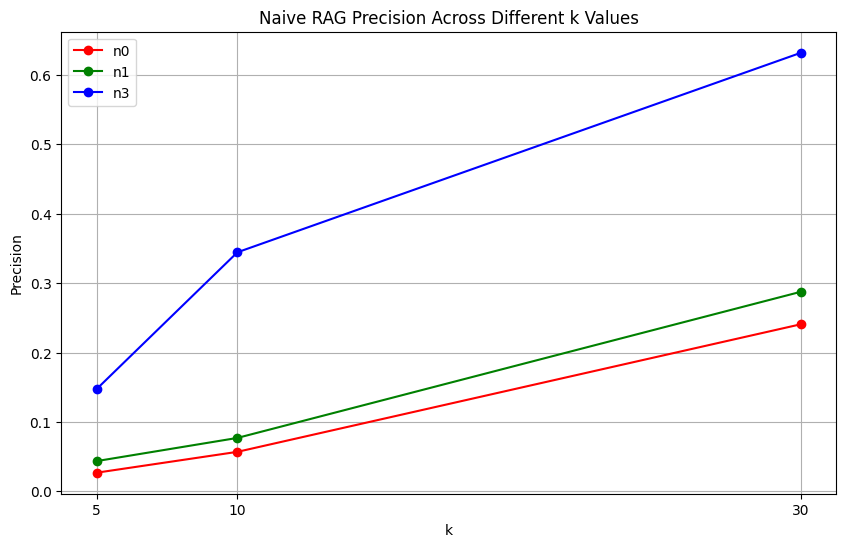

In [204]:
import matplotlib.pyplot as plt

# Data for Naive RAG
k_values = [5, 10, 30]
naive_rag_precision_n0 = [0.026755852842809364, 0.056856187290969896, 0.2408026755852843]
naive_rag_precision_n1 = [0.043478260869565216, 0.07692307692307693, 0.28762541806020064]
naive_rag_precision_n3 = [0.14715719063545152, 0.34448160535117056, 0.6321070234113713]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, naive_rag_precision_n0, marker='o', linestyle='-', color='r', label='n0')
plt.plot(k_values, naive_rag_precision_n1, marker='o', linestyle='-', color='g', label='n1')
plt.plot(k_values, naive_rag_precision_n3, marker='o', linestyle='-', color='b', label='n3')

# Labels and title
plt.xlabel('k')
plt.ylabel('Precision')
plt.title('Naive RAG Precision Across Different k Values')
plt.xticks(k_values)
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [243]:
# Comparing the top 1 node for the naive and the reranker
# for k = 5

#From the k5 and n0 nodes of the naive rag get the top 1 nodes and see if they are true positives
k5_n0_nodes = []
k5_n1_nodes = []
k5_n3_nodes = []

k5_n0_reranker_nodes = []
k5_n1_reranker_nodes = []
k5_n3_reranker_nodes = []

for task in results:
    for action in task['k30']:
        k5_n0_nodes.append(task['k5'][action]['novel_nodes'][0])
        k5_n1_nodes.append(task['k5'][action]['novel_nodes'][0])
        k5_n3_nodes.append(task['k5'][action]['novel_nodes'][0])
        
        k5_n0_reranker_nodes.append(task['k5'][action]['reranker_nodes'][0])
        k5_n1_reranker_nodes.append(task['k5'][action]['reranker_nodes'][0])
        k5_n3_reranker_nodes.append(task['k5'][action]['reranker_nodes'][0])
        
# Calculate the number of true positives
k5_n0_true_positives = sum(1 for node in k5_n0_nodes if node['pos_candidate'] == 1)
k5_n1_true_positives = sum(1 for node in k5_n1_nodes if node['pos_candidate_k1'] == 1)
k5_n3_true_positives = sum(1 for node in k5_n3_nodes if node['pos_candidate_k3'] == 1)

k5_n0_reranker_true_positives = sum(1 for node in k5_n0_reranker_nodes if node['pos_candidate'] == 1)
k5_n1_reranker_true_positives = sum(1 for node in k5_n1_reranker_nodes if node['pos_candidate_k1'] == 1)
k5_n3_reranker_true_positives = sum(1 for node in k5_n3_reranker_nodes if node['pos_candidate_k3'] == 1)

print('Naive RAG')
print('k5 n0 true positives:', k5_n0_true_positives)
print('k5 n1 true positives:', k5_n1_true_positives)
print('k5 n3 true positives:', k5_n3_true_positives)

print('Reranker')
print('k5 n0 true positives:', k5_n0_reranker_true_positives)
print('k5 n1 true positives:', k5_n1_reranker_true_positives)
print('k5 n3 true positives:', k5_n3_reranker_true_positives)


Naive RAG
k5 n0 true positives: 1
k5 n1 true positives: 1
k5 n3 true positives: 12
Reranker
k5 n0 true positives: 1
k5 n1 true positives: 1
k5 n3 true positives: 13


In [248]:
# Comparing the top 1 node for the naive and the reranker
# for k = 5

#From the k5 and n0 nodes of the naive rag get the top 1 nodes and see if they are true positives
k5_n0_nodes = []
k5_n1_nodes = []
k5_n3_nodes = []

k5_n0_reranker_nodes = []
k5_n1_reranker_nodes = []
k5_n3_reranker_nodes = []

for task in results:
    for action in task['k5']:
        for i in range(5):
            k5_n0_nodes.append(task['k10'][action]['novel_nodes'][i])
            k5_n1_nodes.append(task['k10'][action]['novel_nodes'][i])
            k5_n3_nodes.append(task['k10'][action]['novel_nodes'][i])
            
            k5_n0_reranker_nodes.append(task['k10'][action]['reranker_nodes'][i])
            k5_n1_reranker_nodes.append(task['k10'][action]['reranker_nodes'][i])
            k5_n3_reranker_nodes.append(task['k10'][action]['reranker_nodes'][i])
        
# Calculate the number of true positives
k5_n0_true_positives = sum(1 for node in k5_n0_nodes if node['pos_candidate'] == 1)
k5_n1_true_positives = sum(1 for node in k5_n1_nodes if node['pos_candidate_k1'] == 1)
k5_n3_true_positives = sum(1 for node in k5_n3_nodes if node['pos_candidate_k3'] == 1)

k5_n0_reranker_true_positives = sum(1 for node in k5_n0_reranker_nodes if node['pos_candidate'] == 1)
k5_n1_reranker_true_positives = sum(1 for node in k5_n1_reranker_nodes if node['pos_candidate_k1'] == 1)
k5_n3_reranker_true_positives = sum(1 for node in k5_n3_reranker_nodes if node['pos_candidate_k3'] == 1)

print('Naive RAG')
print('k5 n0 true positives:', k5_n0_true_positives)
print('k5 n1 true positives:', k5_n1_true_positives)
print('k5 n3 true positives:', k5_n3_true_positives)

print('Reranker')
print('k5 n0 true positives:', k5_n0_reranker_true_positives)
print('k5 n1 true positives:', k5_n1_reranker_true_positives)
print('k5 n3 true positives:', k5_n3_reranker_true_positives)

Naive RAG
k5 n0 true positives: 8
k5 n1 true positives: 15
k5 n3 true positives: 58
Reranker
k5 n0 true positives: 8
k5 n1 true positives: 17
k5 n3 true positives: 57


In [321]:
# Forl all the k and n compare if the nodes in the rerank and naive rag are the same
repeated_nodes_per_task = []
actions_total = 0
total_repeated = 0
for task in results:
    repeated_nodes = []
    for action in task['k30']:
        actions_count = len(task['k30'][action]['novel_nodes'])
        for i in range(5):
            if task['k30'][action]['novel_nodes'][i]['node_id'] == task['k30'][action]['reranker_nodes'][i]['node_id']:# Same order comparation
                #repeated_nodes.append(task['k30'][action]['novel_nodes'][i])
                repeated_nodes_per_task.append(task['k30'][action]['novel_nodes'][i])
        actions_total += 5
    total_repeated += len(repeated_nodes_per_task)
    #repeated_nodes_per_task.append(repeated_nodes)
            
            

print('Total:', actions_total)
print('Repeated:', len(repeated_nodes_per_task))
print('Percentage:', len(repeated_nodes_per_task) / actions_total)


Total: 1495
Repeated: 1190
Percentage: 0.7959866220735786


Repeated nodes count: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

TypeError: unhashable type: 'numpy.ndarray'

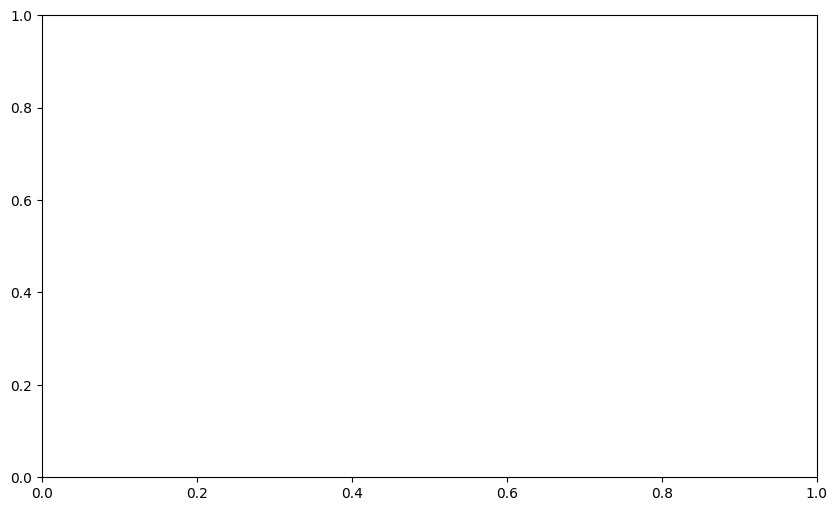

In [318]:
# Plot the amount of repeated nodes per task
repeated_nodes_count = [len(nodes) for nodes in repeated_nodes_per_task]
print('Repeated nodes count:', repeated_nodes_count)

# Plot the amount of repeated nodes for each task
plt.figure(figsize=(10, 6))
plt.bar(range(len(repeated_nodes_count)), repeated_nodes_count)
plt.xlabel('Task')
plt.ylabel('Repeated Nodes')
plt.title('Repeated Nodes Per Task')
plt.grid(True)
plt.show()



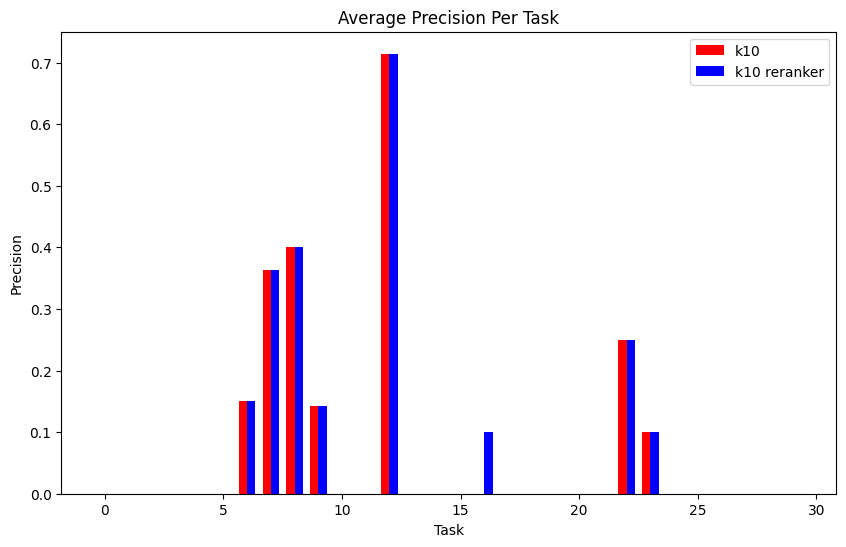

In [323]:
# For all the k and n compare the precision per task
precision_per_task = []
precision_per_task_reranker = []
for task in results:
    task_precision = {'k5': [], 'k10': [], 'k30': []}
    task_precision_reranker = {'k5': [], 'k10': [], 'k30': []}
    for action in task['k30']:
        task_precision['k5'].append(task['k5'][action]['novel']['n0 precision'])
        task_precision['k10'].append(task['k10'][action]['novel']['n0 precision'])
        task_precision['k30'].append(task['k30'][action]['novel']['n0 precision'])
        
        task_precision_reranker['k5'].append(task['k5'][action]['reranker']['n0 precision'])
        task_precision_reranker['k10'].append(task['k10'][action]['reranker']['n0 precision'])
        task_precision_reranker['k30'].append(task['k30'][action]['reranker']['n0 precision'])
    precision_per_task.append(task_precision)
    precision_per_task_reranker.append(task_precision_reranker)
    
# Calculate the average precision per task
average_precision_per_task = []
for task in precision_per_task:
    average_precision = {'k5': 0, 'k10': 0, 'k30': 0}
    for k in ['k5', 'k10', 'k30']:
        average_precision[k] = sum(task[k]) / len(task[k])
    average_precision_per_task.append(average_precision)
    
average_precision_per_task_reranker = []
for task in precision_per_task_reranker:
    average_precision = {'k5': 0, 'k10': 0, 'k30': 0}
    for k in ['k5', 'k10', 'k30']:
        average_precision[k] = sum(task[k]) / len(task[k])
    average_precision_per_task_reranker.append(average_precision)    
    
# Plot the average precision per task
average_precision_k5 = [task['k5'] for task in average_precision_per_task]
average_precision_k10 = [task['k10'] for task in average_precision_per_task]
average_precision_k30 = [task['k30'] for task in average_precision_per_task]

average_precision_k5_reranker = [task['k5'] for task in average_precision_per_task_reranker]
average_precision_k10_reranker = [task['k10'] for task in average_precision_per_task_reranker]
average_precision_k30_reranker = [task['k30'] for task in average_precision_per_task_reranker]

x = np.arange(len(average_precision_k5))  # the label locations
width = 0.35  # 

# Plot the average precision per task
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, average_precision_k10, width, label='k10', color='r')
plt.bar(x + width/2, average_precision_k10_reranker, width, label='k10 reranker', color='b')


# Labels and title
plt.xlabel('Task')
plt.ylabel('Precision')
plt.title('Average Precision Per Task')
plt.legend()
# Show plot
plt.show()

## RAG TO LLM

In [ ]:
# Load models and embeddings

In [ ]:
# Generation prompt
prompt = """You are an autonomous intelligent agent tasked with navigating a web browser. You will be given web-based tasks. Your objective is to find the postive candidates (relevant elements on the website) to complete the task.
Here's the information you'll have:

1- The user's instructions: This is the task you're trying to complete.
2- The current web page's elements to interact with: This is a simplified representation of the webpage, providing key information.
3- The current web page's URL: This is the page you're currently navigating.
4- The web page's domain: This is the field of the website you're currently on.
5- The web page's subdomain: This is the specific section of the website you're currently on.
6- Actions History: This is the history of the actions taken by the agent.

Answer Format: In order to complete the task successfully, you need to provide the positive candidates in the following format:
 - Include all the candidates in the bracket.
 - Separate each candidate by a comma.
 - If there are no candidates, provide an empty bracket.
 
To be successful, it is very important to follow the following rules:
1. You should only issue a candidate that is valid given the current observation and user task
2. You should reason the steps needed to achieve the task, extract what steps have been taken from the ACTIONS HISTORY, and issue the positive candidates for the next step.
3. Issue stop action when you think you have achieved the objective. Don't generate anything after stop.
4. You should not issue the same candidate twice."""